In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'


# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)


from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *
from encoding_information.information_estimation import estimate_mutual_information



2024-10-13 20:02:53.139945: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 20:02:54.634007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-13 20:02:54.634385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-10-13 20:02:54.634402: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Optimize the convolution matrix to map a delta towards a target signal

  0%|                                                   | 0/1 [00:00<?, ?it/s]

initial loss 0.08489868730756678


100%|███████████████████████████████████████████| 1/1 [00:43<00:00, 43.72s/it]


Array(1., dtype=float64)

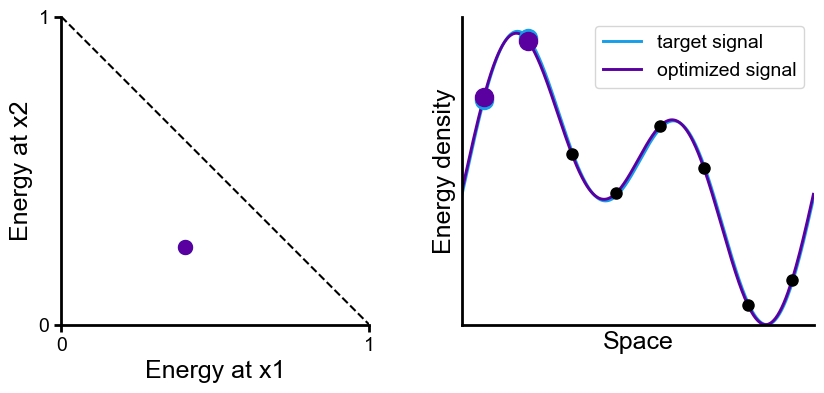

In [2]:
use_sampling_indices = False
sampling_indices = (0, 1)
unit_energy = True
num_nyquist_samples = 4

delta_function = generate_random_object('delta')

target_signal = generate_random_signal(num_nyquist_samples=num_nyquist_samples, unit_energy=unit_energy)
initial_kernel = generate_random_signal(num_nyquist_samples=num_nyquist_samples, unit_energy=True)

optimized_kernels, output_signals, optimized_params = optimize_towards_target_signals(
    [integrate_pixels(target_signal, num_nyquist_samples=num_nyquist_samples)], delta_function, initial_kernel, sampling_indices=sampling_indices if use_sampling_indices else None, verbose=True, return_params=True)
optimized_kernel = optimized_kernels[0]

initial_signal = make_convolutional_encoder(initial_kernel) @ delta_function
optimized_signal = make_convolutional_encoder(optimized_kernel) @ delta_function

# plot target and optimized signal in intensity and spatial coordinates
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_in_intensity_coordinates(ax[0], target_signal, label='target signal', sampling_indices=sampling_indices, num_nyquist_samples=num_nyquist_samples)
plot_in_intensity_coordinates(ax[0], optimized_signal, label='optimized signal', sampling_indices=sampling_indices, num_nyquist_samples=num_nyquist_samples)

plot_in_spatial_coordinates(ax[1], target_signal, label='target signal', sampling_indices=sampling_indices)
plot_in_spatial_coordinates(ax[1], optimized_signal, label='optimized signal', sampling_indices=sampling_indices, show_samples=True)
ax[1].legend()

optimized_signal.sum()

## Plot uniformly random signals

Generating signals: 1067it [00:15, 70.62it/s] 


concatenating...


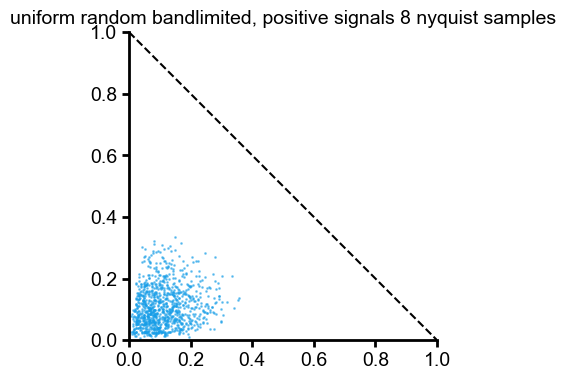

In [3]:
num_nyquist_samples = 8
num_signals = 1000
sampling_indices = (0, 1)

signals = generate_uniform_random_bandlimited_signals(num_nyquist_samples=num_nyquist_samples, num_signals=num_signals)
# signals = np.roll(signals, 64, axis=1)
integrated_signals = integrate_pixels(signals, num_nyquist_samples=num_nyquist_samples)

x1, x2 = integrated_signals[:, sampling_indices[0]], integrated_signals[:, sampling_indices[1]]
# now scatter only the positive targets
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(x1, x2, s=1, alpha=0.5)
# plot dashed line for the L1 ball
ax.plot(np.linspace(0, 1, 100), 1 - np.abs(np.linspace(0, 1, 100)), '--', color='k')
# square axes
ax.set_aspect('equal', 'box')
clear_spines(ax)
ax.set(xlim=(0, 1), ylim=(0, 1))
ax.title.set_text('uniform random bandlimited, positive signals {} nyquist samples'.format(num_nyquist_samples))

## Compare entropy to uniform entropy

In [4]:
from encoding_information.models import PixelCNN, FullGaussianProcess, StationaryGaussianProcess 
from encoding_information.models import AnalyticGaussianNoiseModel
from encoding_information import estimate_information

confidence = 0.95


def compute_mutual_information_for_optimized_encoder(num_objects, num_nyquist_samples, noise_sigma, key,
                                                     upsampled_signal_length=UPSAMPLED_SIGNAL_LENGTH, test_fraction=0.1):
    
    objects_fn = lambda : np.array([generate_random_object('delta', object_size=upsampled_signal_length)
                                     for i in range(num_objects)])

    initial_kernel = generate_random_signal(num_nyquist_samples=num_nyquist_samples, unit_energy=True, upsampled_signal_length=upsampled_signal_length)
    initial_params = params_from_signal(initial_kernel, num_nyquist_samples=num_nyquist_samples)
    loss_fn = make_convolutional_forward_model_with_mi_loss(objects_fn(), noise_sigma, num_nyquist_samples=num_nyquist_samples, 
                                                            upsampled_signal_length=upsampled_signal_length)
    optimized_params = run_optimzation(loss_fn, lambda x : signal_prox_fn(x, num_nyquist_samples=num_nyquist_samples), 
                            initial_params,
                              learning_rate=1e-2, learning_rate_decay=0.999,
                              verbose=True,
                            loss_improvement_patience=2000,
                             max_epochs=3000, 
                             key=key)

    output_signals = conv_forward_model(optimized_params, objects_fn(), num_nyquist_samples=num_nyquist_samples, integrate_output_signals=True, 
                                        upsampled_signal_length=upsampled_signal_length)
    key, subkey = jax.random.split(key)
    noisy_signals = output_signals + noise_sigma * jax.random.normal(subkey, output_signals.shape)

    scale_factor = 1000 # becayse here its 0-1 range
    fake_images = noisy_signals.reshape(-1, int(np.sqrt(num_nyquist_samples)), int(np.sqrt(num_nyquist_samples))) * scale_factor

    train_fake_images = fake_images[:int(fake_images.shape[0] * (1 - test_fraction))]
    test_fake_images = fake_images[int(fake_images.shape[0] * (1 - test_fraction)):]

    pixel_cnn = PixelCNN()
    pixel_cnn.fit(train_fake_images, verbose=False)
    noise_model = AnalyticGaussianNoiseModel(noise_sigma*scale_factor)

    pixel_cnn_info, pixel_cnn_lower_bound, pixel_cnn_upper_bound = estimate_information(
            pixel_cnn, noise_model, train_fake_images, test_fake_images, confidence_interval=confidence)

    return pixel_cnn_info, pixel_cnn_lower_bound, pixel_cnn_upper_bound, subkey

def compute_uniform_samples_mi(num_signals, num_nyquist_samples, noise_sigma, key, upsampled_signal_length=UPSAMPLED_SIGNAL_LENGTH,
                                test_fraction=0.1):
                                
    uniformly_sampled_signals = generate_uniform_random_bandlimited_signals(num_nyquist_samples=num_nyquist_samples, 
                                                                            num_signals=num_signals, upsampled_signal_length=upsampled_signal_length)

    signals = integrate_pixels(uniformly_sampled_signals, num_nyquist_samples=num_nyquist_samples)

    noisy_signals = signals + noise_sigma * jax.random.normal(key, signals.shape)

    scale_factor = 1000 # becayse here its 0-1 range
    fake_images = noisy_signals.reshape(-1, int(np.sqrt(num_nyquist_samples)), int(np.sqrt(num_nyquist_samples))) * scale_factor

    train_fake_images = fake_images[:int(fake_images.shape[0] * (1 - test_fraction))]
    test_fake_images = fake_images[int(fake_images.shape[0] * (1 - test_fraction)):]

    pixel_cnn = PixelCNN()
    pixel_cnn.fit(train_fake_images, verbose=False)
    noise_model = AnalyticGaussianNoiseModel(noise_sigma*scale_factor)

    pixel_cnn_info, pixel_cnn_lower_bound, pixel_cnn_upper_bound = estimate_information(
            pixel_cnn, noise_model, train_fake_images, test_fake_images, confidence_interval=confidence)

    return pixel_cnn_info, pixel_cnn_lower_bound, pixel_cnn_upper_bound


def make_uniform_conv_mi_plot(conv_mi, conv_mi_lower, conv_mi_upper, uniform_mi, uniform_mi_lower, uniform_mi_upper, num_nyquist_samples_list):
        # plot toal mi
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))
        ax.plot(num_nyquist_samples_list, conv_mi, '-o', label='Best encoder')
        ax.fill_between(num_nyquist_samples_list, conv_mi_lower, conv_mi_upper, alpha=0.5, label=f'{confidence}% confidence interval')

        ax.plot(num_nyquist_samples_list, uniform_mi, '-o', label='Optimal signal distribution', color=get_color_cycle()[3])
        ax.fill_between(num_nyquist_samples_list, uniform_mi_lower, uniform_mi_upper, alpha=0.5, label=f'{confidence}% confidence interval', color=get_color_cycle()[3])

        ax.set(xlabel='Signal bandwidth (number of nyquist samples) ', ylabel='Mutual information (bits)')
        clear_spines(ax)
        ax.legend()



Nyquist Samples:   0%|                                  | 0/4 [00:00<?, ?it/s]

initial loss -5.167615489975782


2024-10-13 20:05:33.334479: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:12<41:23, 12.48s/it]

training:   1%|▎                              | 2/200 [00:13<19:31,  5.92s/it]

training:   2%|▍                              | 3/200 [00:15<12:21,  3.77s/it]

training:   2%|▌                              | 4/200 [00:16<09:02,  2.77s/it]

training:   2%|▊                              | 5/200 [00:17<07:12,  2.22s/it]

training:   3%|▉                              | 6/200 [00:18<06:01,  1.86s/it]

training:   4%|█                              | 7/200 [00:19<05:17,  1.64s/it]

training:   4%|█▏                             | 8/200 [00:21<04:51,  1.52s/it]

training:   4%|█▍                             | 9/200 [00:22<0

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:08<28:11,  8.50s/it]

training:   1%|▎                              | 2/200 [00:09<14:11,  4.30s/it]

training:   2%|▍                              | 3/200 [00:11<09:32,  2.91s/it]

training:   2%|▌                              | 4/200 [00:12<07:26,  2.28s/it]

training:   2%|▊                              | 5/200 [00:13<06:14,  1.92s/it]

training:   3%|▉                              | 6/200 [00:15<05:30,  1.71s/it]

training:   4%|█                              | 7/200 [00:16<05:02,  1.57s/it]

training:   4%|█▏                             | 8/200 [00:17<04:43,  1.48s/it]

training:   4%|█▍                             | 9/200 [00:18<04:29,  1.41s/it]

training:   5%|█▌                            | 10/200 [00:20<04:19,  1.37s/it]

training:   6%|█▋                            | 11/200 [00:21<04:12,  1.34s/it]

training:   6%|█▊                     

initial loss -4.837768013014178




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:12<40:52, 12.33s/it]

training:   1%|▎                              | 2/200 [00:13<19:15,  5.84s/it]

training:   2%|▍                              | 3/200 [00:14<12:12,  3.72s/it]

training:   2%|▌                              | 4/200 [00:16<09:02,  2.77s/it]

training:   2%|▊                              | 5/200 [00:17<07:09,  2.20s/it]

training:   3%|▉                              | 6/200 [00:18<06:05,  1.88s/it]

training:   4%|█                              | 7/200 [00:19<05:27,  1.70s/it]

training:   4%|█▏                             | 8/200 [00:21<04:59,  1.56s/it]

training:   4%|█▍                             | 9/200 [00:22<04:41,  1.47s/it]

training:   5%|█▌                            | 10/200 [00:23<04:23,  1.39s/it]

training:   6%|█▋                            | 11/200 [00:24<04:12,  1.34s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:14,  7.31s/it]

training:   1%|▎                              | 2/200 [00:08<12:44,  3.86s/it]

training:   2%|▍                              | 3/200 [00:10<09:01,  2.75s/it]

training:   2%|▌                              | 4/200 [00:11<07:16,  2.22s/it]

training:   2%|▊                              | 5/200 [00:13<06:18,  1.94s/it]

training:   3%|▉                              | 6/200 [00:14<05:46,  1.79s/it]

training:   4%|█                              | 7/200 [00:15<05:23,  1.67s/it]

training:   4%|█▏                             | 8/200 [00:17<05:02,  1.58s/it]

training:   4%|█▍                             | 9/200 [00:18<04:50,  1.52s/it]

training:   5%|█▌                            | 10/200 [00:20<04:41,  1.48s/it]

training:   6%|█▋                            | 11/200 [00:21<04:41,  1.49s/it]

training:   6%|█▊                     

initial loss -3.9320028028332903




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:12<42:01, 12.67s/it]

training:   1%|▎                              | 2/200 [00:14<19:51,  6.02s/it]

training:   2%|▍                              | 3/200 [00:15<13:03,  3.98s/it]

training:   2%|▌                              | 4/200 [00:16<09:35,  2.94s/it]

training:   2%|▊                              | 5/200 [00:18<07:53,  2.43s/it]

training:   3%|▉                              | 6/200 [00:19<06:48,  2.10s/it]

training:   4%|█                              | 7/200 [00:21<06:02,  1.88s/it]

training:   4%|█▏                             | 8/200 [00:22<05:31,  1.73s/it]

training:   4%|█▍                             | 9/200 [00:24<05:13,  1.64s/it]

training:   5%|█▌                            | 10/200 [00:25<04:59,  1.58s/it]

training:   6%|█▋                            | 11/200 [00:26<04:44,  1.50s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<26:21,  7.94s/it]

training:   1%|▎                              | 2/200 [00:09<13:22,  4.05s/it]

training:   2%|▍                              | 3/200 [00:10<09:31,  2.90s/it]

training:   2%|▌                              | 4/200 [00:12<07:34,  2.32s/it]

training:   2%|▊                              | 5/200 [00:13<06:25,  1.98s/it]

training:   3%|▉                              | 6/200 [00:15<05:47,  1.79s/it]

training:   4%|█                              | 7/200 [00:16<05:17,  1.65s/it]

training:   4%|█▏                             | 8/200 [00:17<05:00,  1.57s/it]

training:   4%|█▍                             | 9/200 [00:19<04:49,  1.51s/it]

training:   5%|█▌                            | 10/200 [00:20<04:38,  1.47s/it]

training:   6%|█▋                            | 11/200 [00:21<04:34,  1.45s/it]

training:   6%|█▊                     

initial loss -3.374325974032371




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:12<42:01, 12.67s/it]

training:   1%|▎                              | 2/200 [00:14<20:24,  6.18s/it]

training:   2%|▍                              | 3/200 [00:15<13:13,  4.03s/it]

training:   2%|▌                              | 4/200 [00:17<09:52,  3.02s/it]

training:   2%|▊                              | 5/200 [00:18<08:12,  2.53s/it]

training:   3%|▉                              | 6/200 [00:20<06:58,  2.16s/it]

training:   4%|█                              | 7/200 [00:21<06:14,  1.94s/it]

training:   4%|█▏                             | 8/200 [00:23<05:41,  1.78s/it]

training:   4%|█▍                             | 9/200 [00:24<05:16,  1.66s/it]

training:   5%|█▌                            | 10/200 [00:26<05:05,  1.61s/it]

training:   6%|█▋                            | 11/200 [00:27<04:54,  1.56s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:39,  7.73s/it]

training:   1%|▎                              | 2/200 [00:09<13:24,  4.07s/it]

training:   2%|▍                              | 3/200 [00:10<09:22,  2.86s/it]

training:   2%|▌                              | 4/200 [00:12<07:29,  2.29s/it]

training:   2%|▊                              | 5/200 [00:13<06:26,  1.98s/it]

training:   3%|▉                              | 6/200 [00:15<05:58,  1.85s/it]

training:   4%|█                              | 7/200 [00:16<05:36,  1.74s/it]

training:   4%|█▏                             | 8/200 [00:18<05:13,  1.63s/it]

training:   4%|█▍                             | 9/200 [00:19<04:59,  1.57s/it]

training:   5%|█▌                            | 10/200 [00:20<04:48,  1.52s/it]

training:   6%|█▋                            | 11/200 [00:22<04:39,  1.48s/it]

training:   6%|█▊                     

initial loss -4.660510326444298




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:24,  7.36s/it]

training:   1%|▎                              | 2/200 [00:08<12:51,  3.90s/it]

training:   2%|▍                              | 3/200 [00:10<09:00,  2.75s/it]

training:   2%|▌                              | 4/200 [00:11<07:14,  2.22s/it]

training:   2%|▊                              | 5/200 [00:12<06:09,  1.89s/it]

training:   3%|▉                              | 6/200 [00:14<05:26,  1.68s/it]

training:   4%|█                              | 7/200 [00:15<04:56,  1.54s/it]

training:   4%|█▏                             | 8/200 [00:16<04:38,  1.45s/it]

training:   4%|█▍                             | 9/200 [00:18<04:27,  1.40s/it]

training:   5%|█▌                            | 10/200 [00:19<04:20,  1.37s/it]

training:   6%|█▋                            | 11/200 [00:20<04:18,  1.37s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:51,  7.80s/it]

training:   1%|▎                              | 2/200 [00:09<13:22,  4.05s/it]

training:   2%|▍                              | 3/200 [00:10<09:28,  2.89s/it]

training:   2%|▌                              | 4/200 [00:12<07:34,  2.32s/it]

training:   2%|▊                              | 5/200 [00:13<06:41,  2.06s/it]

training:   3%|▉                              | 6/200 [00:15<06:26,  1.99s/it]

training:   4%|█                              | 7/200 [00:17<05:56,  1.85s/it]

training:   4%|█▏                             | 8/200 [00:18<05:27,  1.70s/it]

training:   4%|█▍                             | 9/200 [00:20<05:10,  1.63s/it]

training:   5%|█▌                            | 10/200 [00:21<05:01,  1.59s/it]

training:   6%|█▋                            | 11/200 [00:23<04:53,  1.55s/it]

training:   6%|█▊                     

initial loss -5.114370331533411




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:54,  7.81s/it]

training:   1%|▎                              | 2/200 [00:09<13:41,  4.15s/it]

training:   2%|▍                              | 3/200 [00:11<10:03,  3.06s/it]

training:   2%|▌                              | 4/200 [00:12<08:10,  2.50s/it]

training:   2%|▊                              | 5/200 [00:14<06:54,  2.12s/it]

training:   3%|▉                              | 6/200 [00:15<06:15,  1.94s/it]

training:   4%|█                              | 7/200 [00:17<05:52,  1.83s/it]

training:   4%|█▏                             | 8/200 [00:18<05:31,  1.73s/it]

training:   4%|█▍                             | 9/200 [00:20<05:14,  1.65s/it]

training:   5%|█▌                            | 10/200 [00:21<04:55,  1.55s/it]

training:   6%|█▋                            | 11/200 [00:23<04:48,  1.52s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<26:01,  7.85s/it]

training:   1%|▎                              | 2/200 [00:09<13:27,  4.08s/it]

training:   2%|▍                              | 3/200 [00:10<09:22,  2.86s/it]

training:   2%|▌                              | 4/200 [00:12<07:26,  2.28s/it]

training:   2%|▊                              | 5/200 [00:13<06:23,  1.97s/it]

training:   3%|▉                              | 6/200 [00:14<05:42,  1.77s/it]

training:   4%|█                              | 7/200 [00:16<05:17,  1.65s/it]

training:   4%|█▏                             | 8/200 [00:17<04:55,  1.54s/it]

training:   4%|█▍                             | 9/200 [00:19<04:50,  1.52s/it]

training:   5%|█▌                            | 10/200 [00:20<04:50,  1.53s/it]

training:   6%|█▋                            | 11/200 [00:22<04:48,  1.53s/it]

training:   6%|█▊                     

initial loss -3.974320417216375




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:40,  7.44s/it]

training:   1%|▎                              | 2/200 [00:08<12:50,  3.89s/it]

training:   2%|▍                              | 3/200 [00:10<08:59,  2.74s/it]

training:   2%|▌                              | 4/200 [00:11<07:09,  2.19s/it]

training:   2%|▊                              | 5/200 [00:12<06:08,  1.89s/it]

training:   3%|▉                              | 6/200 [00:14<05:32,  1.71s/it]

training:   4%|█                              | 7/200 [00:15<05:15,  1.64s/it]

training:   4%|█▏                             | 8/200 [00:17<04:58,  1.55s/it]

training:   4%|█▍                             | 9/200 [00:18<04:48,  1.51s/it]

training:   5%|█▌                            | 10/200 [00:19<04:32,  1.44s/it]

training:   6%|█▋                            | 11/200 [00:21<04:23,  1.39s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<26:26,  7.97s/it]

training:   1%|▎                              | 2/200 [00:09<13:43,  4.16s/it]

training:   2%|▍                              | 3/200 [00:10<09:33,  2.91s/it]

training:   2%|▌                              | 4/200 [00:12<07:48,  2.39s/it]

training:   2%|▊                              | 5/200 [00:13<06:37,  2.04s/it]

training:   3%|▉                              | 6/200 [00:15<06:10,  1.91s/it]

training:   4%|█                              | 7/200 [00:17<05:43,  1.78s/it]

training:   4%|█▏                             | 8/200 [00:18<05:20,  1.67s/it]

training:   4%|█▍                             | 9/200 [00:19<05:06,  1.61s/it]

training:   5%|█▌                            | 10/200 [00:21<04:52,  1.54s/it]

training:   6%|█▋                            | 11/200 [00:22<04:50,  1.54s/it]

training:   6%|█▊                     

initial loss -3.271825199956027




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:25,  7.67s/it]

training:   1%|▎                              | 2/200 [00:09<13:44,  4.16s/it]

training:   2%|▍                              | 3/200 [00:10<09:50,  3.00s/it]

training:   2%|▌                              | 4/200 [00:12<08:09,  2.50s/it]

training:   2%|▊                              | 5/200 [00:14<07:22,  2.27s/it]

training:   3%|▉                              | 6/200 [00:16<06:31,  2.02s/it]

training:   4%|█                              | 7/200 [00:17<05:58,  1.86s/it]

training:   4%|█▏                             | 8/200 [00:19<05:41,  1.78s/it]

training:   4%|█▍                             | 9/200 [00:20<05:33,  1.75s/it]

training:   5%|█▌                            | 10/200 [00:22<05:24,  1.71s/it]

training:   6%|█▋                            | 11/200 [00:24<05:24,  1.72s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:14,  7.61s/it]

training:   1%|▎                              | 2/200 [00:09<13:15,  4.02s/it]

training:   2%|▍                              | 3/200 [00:10<09:30,  2.89s/it]

training:   2%|▌                              | 4/200 [00:12<07:50,  2.40s/it]

training:   2%|▊                              | 5/200 [00:13<06:43,  2.07s/it]

training:   3%|▉                              | 6/200 [00:15<05:59,  1.85s/it]

training:   4%|█                              | 7/200 [00:16<05:46,  1.79s/it]

training:   4%|█▏                             | 8/200 [00:18<05:28,  1.71s/it]

training:   4%|█▍                             | 9/200 [00:19<05:13,  1.64s/it]

training:   5%|█▌                            | 10/200 [00:21<05:06,  1.62s/it]

training:   6%|█▋                            | 11/200 [00:23<05:10,  1.65s/it]

training:   6%|█▊                     

initial loss -5.217542919050387




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<23:41,  7.14s/it]

training:   1%|▎                              | 2/200 [00:08<12:21,  3.74s/it]

training:   2%|▍                              | 3/200 [00:09<08:33,  2.61s/it]

training:   2%|▌                              | 4/200 [00:11<06:46,  2.08s/it]

training:   2%|▊                              | 5/200 [00:12<05:46,  1.78s/it]

training:   3%|▉                              | 6/200 [00:13<05:17,  1.64s/it]

training:   4%|█                              | 7/200 [00:14<04:53,  1.52s/it]

training:   4%|█▏                             | 8/200 [00:16<04:35,  1.43s/it]

training:   4%|█▍                             | 9/200 [00:17<04:25,  1.39s/it]

training:   5%|█▌                            | 10/200 [00:18<04:19,  1.36s/it]

training:   6%|█▋                            | 11/200 [00:20<04:14,  1.35s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<26:20,  7.94s/it]

training:   1%|▎                              | 2/200 [00:09<14:03,  4.26s/it]

training:   2%|▍                              | 3/200 [00:11<09:49,  2.99s/it]

training:   2%|▌                              | 4/200 [00:12<07:50,  2.40s/it]

training:   2%|▊                              | 5/200 [00:14<06:43,  2.07s/it]

training:   3%|▉                              | 6/200 [00:15<06:07,  1.89s/it]

training:   4%|█                              | 7/200 [00:17<05:46,  1.80s/it]

training:   4%|█▏                             | 8/200 [00:18<05:33,  1.74s/it]

training:   4%|█▍                             | 9/200 [00:20<05:17,  1.66s/it]

training:   5%|█▌                            | 10/200 [00:22<05:23,  1.70s/it]

training:   6%|█▋                            | 11/200 [00:23<05:16,  1.67s/it]

training:   6%|█▊                     

initial loss -4.721185662807849




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:24,  7.36s/it]

training:   1%|▎                              | 2/200 [00:08<13:04,  3.96s/it]

training:   2%|▍                              | 3/200 [00:10<09:07,  2.78s/it]

training:   2%|▌                              | 4/200 [00:11<07:12,  2.21s/it]

training:   2%|▊                              | 5/200 [00:12<06:10,  1.90s/it]

training:   3%|▉                              | 6/200 [00:14<05:38,  1.75s/it]

training:   4%|█                              | 7/200 [00:15<05:14,  1.63s/it]

training:   4%|█▏                             | 8/200 [00:17<04:57,  1.55s/it]

training:   4%|█▍                             | 9/200 [00:18<04:44,  1.49s/it]

training:   5%|█▌                            | 10/200 [00:19<04:39,  1.47s/it]

training:   6%|█▋                            | 11/200 [00:21<04:36,  1.46s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:47,  7.47s/it]

training:   1%|▎                              | 2/200 [00:09<13:10,  3.99s/it]

training:   2%|▍                              | 3/200 [00:10<09:22,  2.85s/it]

training:   2%|▌                              | 4/200 [00:12<07:40,  2.35s/it]

training:   2%|▊                              | 5/200 [00:13<06:34,  2.02s/it]

training:   3%|▉                              | 6/200 [00:15<06:02,  1.87s/it]

training:   4%|█                              | 7/200 [00:16<05:35,  1.74s/it]

training:   4%|█▏                             | 8/200 [00:18<05:19,  1.67s/it]

training:   4%|█▍                             | 9/200 [00:19<05:10,  1.63s/it]

training:   5%|█▌                            | 10/200 [00:21<05:12,  1.64s/it]

training:   6%|█▋                            | 11/200 [00:23<05:15,  1.67s/it]

training:   6%|█▊                     

initial loss -3.450832561585959




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:44,  7.46s/it]

training:   1%|▎                              | 2/200 [00:09<13:14,  4.01s/it]

training:   2%|▍                              | 3/200 [00:10<09:37,  2.93s/it]

training:   2%|▌                              | 4/200 [00:12<07:45,  2.37s/it]

training:   2%|▊                              | 5/200 [00:13<06:42,  2.07s/it]

training:   3%|▉                              | 6/200 [00:15<06:03,  1.87s/it]

training:   4%|█                              | 7/200 [00:16<05:34,  1.73s/it]

training:   4%|█▏                             | 8/200 [00:18<05:19,  1.66s/it]

training:   4%|█▍                             | 9/200 [00:19<05:04,  1.59s/it]

training:   5%|█▌                            | 10/200 [00:21<04:59,  1.58s/it]

training:   6%|█▋                            | 11/200 [00:22<04:49,  1.53s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:03,  7.56s/it]

training:   1%|▎                              | 2/200 [00:09<13:20,  4.04s/it]

training:   2%|▍                              | 3/200 [00:10<09:27,  2.88s/it]

training:   2%|▌                              | 4/200 [00:12<07:33,  2.31s/it]

training:   2%|▊                              | 5/200 [00:13<06:34,  2.02s/it]

training:   3%|▉                              | 6/200 [00:15<05:56,  1.84s/it]

training:   4%|█                              | 7/200 [00:16<05:34,  1.73s/it]

training:   4%|█▏                             | 8/200 [00:18<05:15,  1.64s/it]

training:   4%|█▍                             | 9/200 [00:19<04:58,  1.56s/it]

training:   5%|█▌                            | 10/200 [00:20<04:46,  1.51s/it]

training:   6%|█▋                            | 11/200 [00:22<04:46,  1.52s/it]

training:   6%|█▊                     

initial loss -3.7096301678360897




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:06,  7.57s/it]

training:   1%|▎                              | 2/200 [00:09<13:25,  4.07s/it]

training:   2%|▍                              | 3/200 [00:10<09:36,  2.93s/it]

training:   2%|▌                              | 4/200 [00:13<08:53,  2.72s/it]

training:   2%|▊                              | 5/200 [00:15<07:59,  2.46s/it]

training:   3%|▉                              | 6/200 [00:16<06:53,  2.13s/it]

training:   4%|█                              | 7/200 [00:18<06:12,  1.93s/it]

training:   4%|█▏                             | 8/200 [00:19<05:42,  1.78s/it]

training:   4%|█▍                             | 9/200 [00:21<05:22,  1.69s/it]

training:   5%|█▌                            | 10/200 [00:22<05:09,  1.63s/it]

training:   6%|█▋                            | 11/200 [00:24<05:02,  1.60s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:08<26:47,  8.08s/it]

training:   1%|▎                              | 2/200 [00:09<14:11,  4.30s/it]

training:   2%|▍                              | 3/200 [00:11<10:03,  3.06s/it]

training:   2%|▌                              | 4/200 [00:12<08:05,  2.48s/it]

training:   2%|▊                              | 5/200 [00:14<07:03,  2.17s/it]

training:   3%|▉                              | 6/200 [00:16<06:35,  2.04s/it]

training:   4%|█                              | 7/200 [00:17<06:04,  1.89s/it]

training:   4%|█▏                             | 8/200 [00:19<05:49,  1.82s/it]

training:   4%|█▍                             | 9/200 [00:21<05:31,  1.74s/it]

training:   5%|█▌                            | 10/200 [00:22<05:30,  1.74s/it]

training:   6%|█▋                            | 11/200 [00:24<05:35,  1.77s/it]

training:   6%|█▊                     

initial loss -4.890302808628405




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:22,  7.65s/it]

training:   1%|▎                              | 2/200 [00:09<13:07,  3.97s/it]

training:   2%|▍                              | 3/200 [00:10<09:16,  2.83s/it]

training:   2%|▌                              | 4/200 [00:11<07:21,  2.25s/it]

training:   2%|▊                              | 5/200 [00:13<06:22,  1.96s/it]

training:   3%|▉                              | 6/200 [00:14<05:44,  1.77s/it]

training:   4%|█                              | 7/200 [00:16<05:20,  1.66s/it]

training:   4%|█▏                             | 8/200 [00:17<05:12,  1.63s/it]

training:   4%|█▍                             | 9/200 [00:19<05:15,  1.65s/it]

training:   5%|█▌                            | 10/200 [00:20<04:59,  1.58s/it]

training:   6%|█▋                            | 11/200 [00:22<04:48,  1.53s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:51,  7.50s/it]

training:   1%|▎                              | 2/200 [00:08<13:05,  3.97s/it]

training:   2%|▍                              | 3/200 [00:10<09:16,  2.83s/it]

training:   2%|▌                              | 4/200 [00:11<07:20,  2.25s/it]

training:   2%|▊                              | 5/200 [00:13<06:17,  1.94s/it]

training:   3%|▉                              | 6/200 [00:14<05:38,  1.74s/it]

training:   4%|█                              | 7/200 [00:16<05:20,  1.66s/it]

training:   4%|█▏                             | 8/200 [00:17<05:04,  1.59s/it]

training:   4%|█▍                             | 9/200 [00:18<04:53,  1.54s/it]

training:   5%|█▌                            | 10/200 [00:20<04:41,  1.48s/it]

training:   6%|█▋                            | 11/200 [00:21<04:32,  1.44s/it]

training:   6%|█▊                     

initial loss -4.763499165001471




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:23,  7.36s/it]

training:   1%|▎                              | 2/200 [00:08<12:40,  3.84s/it]

training:   2%|▍                              | 3/200 [00:10<08:45,  2.67s/it]

training:   2%|▌                              | 4/200 [00:11<06:55,  2.12s/it]

training:   2%|▊                              | 5/200 [00:12<05:53,  1.81s/it]

training:   3%|▉                              | 6/200 [00:13<05:21,  1.66s/it]

training:   4%|█                              | 7/200 [00:15<05:02,  1.57s/it]

training:   4%|█▏                             | 8/200 [00:16<04:50,  1.51s/it]

training:   4%|█▍                             | 9/200 [00:18<04:39,  1.46s/it]

training:   5%|█▌                            | 10/200 [00:19<04:34,  1.44s/it]

training:   6%|█▋                            | 11/200 [00:20<04:25,  1.40s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:15,  7.31s/it]

training:   1%|▎                              | 2/200 [00:08<12:41,  3.85s/it]

training:   2%|▍                              | 3/200 [00:10<09:03,  2.76s/it]

training:   2%|▌                              | 4/200 [00:11<07:19,  2.24s/it]

training:   2%|▊                              | 5/200 [00:12<06:14,  1.92s/it]

training:   3%|▉                              | 6/200 [00:14<05:38,  1.74s/it]

training:   4%|█                              | 7/200 [00:15<05:19,  1.66s/it]

training:   4%|█▏                             | 8/200 [00:17<05:01,  1.57s/it]

training:   4%|█▍                             | 9/200 [00:18<04:50,  1.52s/it]

training:   5%|█▌                            | 10/200 [00:20<04:50,  1.53s/it]

training:   6%|█▋                            | 11/200 [00:21<04:43,  1.50s/it]

training:   6%|█▊                     

initial loss -3.8661539583049107




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:08<27:01,  8.15s/it]

training:   1%|▎                              | 2/200 [00:09<13:47,  4.18s/it]

training:   2%|▍                              | 3/200 [00:10<09:34,  2.92s/it]

training:   2%|▌                              | 4/200 [00:12<07:38,  2.34s/it]

training:   2%|▊                              | 5/200 [00:13<06:28,  1.99s/it]

training:   3%|▉                              | 6/200 [00:15<05:47,  1.79s/it]

training:   4%|█                              | 7/200 [00:16<05:20,  1.66s/it]

training:   4%|█▏                             | 8/200 [00:18<05:05,  1.59s/it]

training:   4%|█▍                             | 9/200 [00:19<04:46,  1.50s/it]

training:   5%|█▌                            | 10/200 [00:20<04:40,  1.47s/it]

training:   6%|█▋                            | 11/200 [00:22<04:54,  1.56s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:14,  7.31s/it]

training:   1%|▎                              | 2/200 [00:08<13:05,  3.97s/it]

training:   2%|▍                              | 3/200 [00:10<09:20,  2.84s/it]

training:   2%|▌                              | 4/200 [00:12<07:38,  2.34s/it]

training:   2%|▊                              | 5/200 [00:13<06:45,  2.08s/it]

training:   3%|▉                              | 6/200 [00:15<06:33,  2.03s/it]

training:   4%|█                              | 7/200 [00:17<06:31,  2.03s/it]

training:   4%|█▏                             | 8/200 [00:19<06:33,  2.05s/it]

training:   4%|█▍                             | 9/200 [00:21<05:51,  1.84s/it]

training:   5%|█▌                            | 10/200 [00:22<05:27,  1.72s/it]

training:   6%|█▋                            | 11/200 [00:24<05:19,  1.69s/it]

training:   6%|█▊                     

initial loss -3.492791622577864




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:51,  7.79s/it]

training:   1%|▎                              | 2/200 [00:09<13:38,  4.13s/it]

training:   2%|▍                              | 3/200 [00:10<09:40,  2.95s/it]

training:   2%|▌                              | 4/200 [00:12<07:50,  2.40s/it]

training:   2%|▊                              | 5/200 [00:13<06:47,  2.09s/it]

training:   3%|▉                              | 6/200 [00:15<06:03,  1.88s/it]

training:   4%|█                              | 7/200 [00:17<05:44,  1.79s/it]

training:   4%|█▏                             | 8/200 [00:18<05:25,  1.70s/it]

training:   4%|█▍                             | 9/200 [00:20<05:24,  1.70s/it]

training:   5%|█▌                            | 10/200 [00:21<05:19,  1.68s/it]

training:   6%|█▋                            | 11/200 [00:23<05:05,  1.62s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:23,  7.66s/it]

training:   1%|▎                              | 2/200 [00:09<13:27,  4.08s/it]

training:   2%|▍                              | 3/200 [00:10<09:36,  2.93s/it]

training:   2%|▌                              | 4/200 [00:12<07:40,  2.35s/it]

training:   2%|▊                              | 5/200 [00:14<07:04,  2.18s/it]

training:   3%|▉                              | 6/200 [00:15<06:22,  1.97s/it]

training:   4%|█                              | 7/200 [00:17<05:56,  1.85s/it]

training:   4%|█▏                             | 8/200 [00:18<05:34,  1.74s/it]

training:   4%|█▍                             | 9/200 [00:20<05:24,  1.70s/it]

training:   5%|█▌                            | 10/200 [00:22<05:17,  1.67s/it]

training:   6%|█▋                            | 11/200 [00:23<05:05,  1.62s/it]

training:   6%|█▊                     

initial loss -5.206484286328587




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<23:46,  7.17s/it]

training:   1%|▎                              | 2/200 [00:08<12:31,  3.80s/it]

training:   2%|▍                              | 3/200 [00:10<08:55,  2.72s/it]

training:   2%|▌                              | 4/200 [00:11<07:14,  2.22s/it]

training:   2%|▊                              | 5/200 [00:12<06:21,  1.96s/it]

training:   3%|▉                              | 6/200 [00:14<05:50,  1.81s/it]

training:   4%|█                              | 7/200 [00:15<05:25,  1.69s/it]

training:   4%|█▏                             | 8/200 [00:17<05:13,  1.63s/it]

training:   4%|█▍                             | 9/200 [00:18<04:56,  1.55s/it]

training:   5%|█▌                            | 10/200 [00:20<04:42,  1.49s/it]

training:   6%|█▋                            | 11/200 [00:21<04:32,  1.44s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:00,  7.24s/it]

training:   1%|▎                              | 2/200 [00:08<12:25,  3.76s/it]

training:   2%|▍                              | 3/200 [00:09<08:40,  2.64s/it]

training:   2%|▌                              | 4/200 [00:11<06:54,  2.12s/it]

training:   2%|▊                              | 5/200 [00:12<05:58,  1.84s/it]

training:   3%|▉                              | 6/200 [00:13<05:27,  1.69s/it]

training:   4%|█                              | 7/200 [00:15<05:00,  1.56s/it]

training:   4%|█▏                             | 8/200 [00:16<04:44,  1.48s/it]

training:   4%|█▍                             | 9/200 [00:17<04:30,  1.42s/it]

training:   5%|█▌                            | 10/200 [00:19<04:22,  1.38s/it]

training:   6%|█▋                            | 11/200 [00:20<04:13,  1.34s/it]

training:   6%|█▊                     

initial loss -5.107080906436135




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<23:48,  7.18s/it]

training:   1%|▎                              | 2/200 [00:08<12:13,  3.71s/it]

training:   2%|▍                              | 3/200 [00:09<08:39,  2.63s/it]

training:   2%|▌                              | 4/200 [00:11<06:49,  2.09s/it]

training:   2%|▊                              | 5/200 [00:12<05:45,  1.77s/it]

training:   3%|▉                              | 6/200 [00:13<05:05,  1.58s/it]

training:   4%|█                              | 7/200 [00:14<04:40,  1.45s/it]

training:   4%|█▏                             | 8/200 [00:15<04:24,  1.38s/it]

training:   4%|█▍                             | 9/200 [00:17<04:12,  1.32s/it]

training:   5%|█▌                            | 10/200 [00:18<04:04,  1.29s/it]

training:   6%|█▋                            | 11/200 [00:19<04:00,  1.27s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<23:36,  7.12s/it]

training:   1%|▎                              | 2/200 [00:08<12:18,  3.73s/it]

training:   2%|▍                              | 3/200 [00:09<08:35,  2.62s/it]

training:   2%|▌                              | 4/200 [00:11<06:55,  2.12s/it]

training:   2%|▊                              | 5/200 [00:12<05:56,  1.83s/it]

training:   3%|▉                              | 6/200 [00:13<05:20,  1.65s/it]

training:   4%|█                              | 7/200 [00:15<04:59,  1.55s/it]

training:   4%|█▏                             | 8/200 [00:16<04:42,  1.47s/it]

training:   4%|█▍                             | 9/200 [00:17<04:33,  1.43s/it]

training:   5%|█▌                            | 10/200 [00:19<04:38,  1.47s/it]

training:   6%|█▋                            | 11/200 [00:20<04:31,  1.44s/it]

training:   6%|█▊                     

initial loss -4.157806554272215




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:59,  7.84s/it]

training:   1%|▎                              | 2/200 [00:09<13:41,  4.15s/it]

training:   2%|▍                              | 3/200 [00:11<10:09,  3.09s/it]

training:   2%|▌                              | 4/200 [00:13<09:03,  2.77s/it]

training:   2%|▊                              | 5/200 [00:15<08:02,  2.47s/it]

training:   3%|▉                              | 6/200 [00:16<06:47,  2.10s/it]

training:   4%|█                              | 7/200 [00:18<06:01,  1.87s/it]

training:   4%|█▏                             | 8/200 [00:19<05:29,  1.72s/it]

training:   4%|█▍                             | 9/200 [00:20<05:03,  1.59s/it]

training:   5%|█▌                            | 10/200 [00:22<04:49,  1.53s/it]

training:   6%|█▋                            | 11/200 [00:23<04:43,  1.50s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:08<27:22,  8.25s/it]

training:   1%|▎                              | 2/200 [00:09<14:16,  4.32s/it]

training:   2%|▍                              | 3/200 [00:11<09:56,  3.03s/it]

training:   2%|▌                              | 4/200 [00:12<07:56,  2.43s/it]

training:   2%|▊                              | 5/200 [00:14<06:36,  2.03s/it]

training:   3%|▉                              | 6/200 [00:15<05:56,  1.84s/it]

training:   4%|█                              | 7/200 [00:17<05:36,  1.75s/it]

training:   4%|█▏                             | 8/200 [00:18<05:18,  1.66s/it]

training:   4%|█▍                             | 9/200 [00:20<05:10,  1.63s/it]

training:   5%|█▌                            | 10/200 [00:21<04:55,  1.55s/it]

training:   6%|█▋                            | 11/200 [00:22<04:38,  1.47s/it]

training:   6%|█▊                     

initial loss -3.769687280897596




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<23:39,  7.13s/it]

training:   1%|▎                              | 2/200 [00:08<12:35,  3.82s/it]

training:   2%|▍                              | 3/200 [00:10<08:54,  2.71s/it]

training:   2%|▌                              | 4/200 [00:11<07:06,  2.18s/it]

training:   2%|▊                              | 5/200 [00:12<06:07,  1.88s/it]

training:   3%|▉                              | 6/200 [00:14<05:33,  1.72s/it]

training:   4%|█                              | 7/200 [00:15<05:28,  1.70s/it]

training:   4%|█▏                             | 8/200 [00:17<05:08,  1.61s/it]

training:   4%|█▍                             | 9/200 [00:18<04:53,  1.54s/it]

training:   5%|█▌                            | 10/200 [00:19<04:41,  1.48s/it]

training:   6%|█▋                            | 11/200 [00:21<04:32,  1.44s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:08<26:32,  8.00s/it]

training:   1%|▎                              | 2/200 [00:09<14:00,  4.24s/it]

training:   2%|▍                              | 3/200 [00:11<09:42,  2.96s/it]

training:   2%|▌                              | 4/200 [00:12<07:45,  2.37s/it]

training:   2%|▊                              | 5/200 [00:13<06:39,  2.05s/it]

training:   3%|▉                              | 6/200 [00:15<05:58,  1.85s/it]

training:   4%|█                              | 7/200 [00:16<05:32,  1.72s/it]

training:   4%|█▏                             | 8/200 [00:18<05:21,  1.67s/it]

training:   4%|█▍                             | 9/200 [00:19<05:04,  1.59s/it]

training:   5%|█▌                            | 10/200 [00:21<04:57,  1.57s/it]

training:   6%|█▋                            | 11/200 [00:23<05:05,  1.62s/it]

training:   6%|█▊                     

initial loss -5.106934598990834




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:06<23:04,  6.96s/it]

training:   1%|▎                              | 2/200 [00:08<12:05,  3.66s/it]

training:   2%|▍                              | 3/200 [00:09<08:30,  2.59s/it]

training:   2%|▌                              | 4/200 [00:10<06:51,  2.10s/it]

training:   2%|▊                              | 5/200 [00:12<05:54,  1.82s/it]

training:   3%|▉                              | 6/200 [00:13<05:20,  1.65s/it]

training:   4%|█                              | 7/200 [00:14<04:57,  1.54s/it]

training:   4%|█▏                             | 8/200 [00:16<04:39,  1.46s/it]

training:   4%|█▍                             | 9/200 [00:17<04:30,  1.41s/it]

training:   5%|█▌                            | 10/200 [00:18<04:24,  1.39s/it]

training:   6%|█▋                            | 11/200 [00:20<04:20,  1.38s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:25,  7.66s/it]

training:   1%|▎                              | 2/200 [00:08<12:59,  3.94s/it]

training:   2%|▍                              | 3/200 [00:10<08:57,  2.73s/it]

training:   2%|▌                              | 4/200 [00:11<07:04,  2.17s/it]

training:   2%|▊                              | 5/200 [00:12<06:03,  1.86s/it]

training:   3%|▉                              | 6/200 [00:14<05:26,  1.68s/it]

training:   4%|█                              | 7/200 [00:15<05:00,  1.56s/it]

training:   4%|█▏                             | 8/200 [00:16<04:45,  1.49s/it]

training:   4%|█▍                             | 9/200 [00:18<04:28,  1.40s/it]

training:   5%|█▌                            | 10/200 [00:19<04:22,  1.38s/it]

training:   6%|█▋                            | 11/200 [00:20<04:14,  1.34s/it]

training:   6%|█▊                     

initial loss -4.340581843256334




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<23:52,  7.20s/it]

training:   1%|▎                              | 2/200 [00:08<12:49,  3.89s/it]

training:   2%|▍                              | 3/200 [00:10<08:56,  2.73s/it]

training:   2%|▌                              | 4/200 [00:11<07:07,  2.18s/it]

training:   2%|▊                              | 5/200 [00:12<06:00,  1.85s/it]

training:   3%|▉                              | 6/200 [00:14<05:21,  1.66s/it]

training:   4%|█                              | 7/200 [00:15<04:55,  1.53s/it]

training:   4%|█▏                             | 8/200 [00:16<04:36,  1.44s/it]

training:   4%|█▍                             | 9/200 [00:17<04:25,  1.39s/it]

training:   5%|█▌                            | 10/200 [00:19<04:16,  1.35s/it]

training:   6%|█▋                            | 11/200 [00:20<04:14,  1.35s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:06<23:08,  6.98s/it]

training:   1%|▎                              | 2/200 [00:08<11:56,  3.62s/it]

training:   2%|▍                              | 3/200 [00:09<08:21,  2.54s/it]

training:   2%|▌                              | 4/200 [00:10<06:44,  2.06s/it]

training:   2%|▊                              | 5/200 [00:12<05:48,  1.79s/it]

training:   3%|▉                              | 6/200 [00:13<05:12,  1.61s/it]

training:   4%|█                              | 7/200 [00:14<04:47,  1.49s/it]

training:   4%|█▏                             | 8/200 [00:15<04:35,  1.43s/it]

training:   4%|█▍                             | 9/200 [00:17<04:22,  1.37s/it]

training:   5%|█▌                            | 10/200 [00:18<04:10,  1.32s/it]

training:   6%|█▋                            | 11/200 [00:19<04:09,  1.32s/it]

training:   6%|█▊                     

initial loss -3.7862902059043932




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<23:45,  7.16s/it]

training:   1%|▎                              | 2/200 [00:08<12:32,  3.80s/it]

training:   2%|▍                              | 3/200 [00:09<08:48,  2.68s/it]

training:   2%|▌                              | 4/200 [00:11<06:58,  2.13s/it]

training:   2%|▊                              | 5/200 [00:12<05:59,  1.84s/it]

training:   3%|▉                              | 6/200 [00:13<05:25,  1.68s/it]

training:   4%|█                              | 7/200 [00:15<05:15,  1.64s/it]

training:   4%|█▏                             | 8/200 [00:16<04:53,  1.53s/it]

training:   4%|█▍                             | 9/200 [00:18<04:39,  1.46s/it]

training:   5%|█▌                            | 10/200 [00:19<04:30,  1.42s/it]

training:   6%|█▋                            | 11/200 [00:20<04:25,  1.41s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:06<23:11,  6.99s/it]

training:   1%|▎                              | 2/200 [00:08<12:13,  3.70s/it]

training:   2%|▍                              | 3/200 [00:09<08:33,  2.61s/it]

training:   2%|▌                              | 4/200 [00:11<06:50,  2.09s/it]

training:   2%|▊                              | 5/200 [00:12<05:52,  1.81s/it]

training:   3%|▉                              | 6/200 [00:13<05:14,  1.62s/it]

training:   4%|█                              | 7/200 [00:14<04:54,  1.52s/it]

training:   4%|█▏                             | 8/200 [00:16<04:37,  1.44s/it]

training:   4%|█▍                             | 9/200 [00:17<04:28,  1.41s/it]

training:   5%|█▌                            | 10/200 [00:18<04:24,  1.39s/it]

training:   6%|█▋                            | 11/200 [00:20<04:19,  1.37s/it]

training:   6%|█▊                     

initial loss -3.2054544380119956




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:18,  7.63s/it]

training:   1%|▎                              | 2/200 [00:09<13:25,  4.07s/it]

training:   2%|▍                              | 3/200 [00:10<09:28,  2.89s/it]

training:   2%|▌                              | 4/200 [00:12<07:37,  2.34s/it]

training:   2%|▊                              | 5/200 [00:13<06:44,  2.07s/it]

training:   3%|▉                              | 6/200 [00:15<06:08,  1.90s/it]

training:   4%|█                              | 7/200 [00:16<05:45,  1.79s/it]

training:   4%|█▏                             | 8/200 [00:18<05:25,  1.69s/it]

training:   4%|█▍                             | 9/200 [00:20<05:23,  1.69s/it]

training:   5%|█▌                            | 10/200 [00:21<05:19,  1.68s/it]

training:   6%|█▋                            | 11/200 [00:23<05:04,  1.61s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:35,  7.42s/it]

training:   1%|▎                              | 2/200 [00:08<12:56,  3.92s/it]

training:   2%|▍                              | 3/200 [00:10<09:04,  2.77s/it]

training:   2%|▌                              | 4/200 [00:11<07:19,  2.24s/it]

training:   2%|▊                              | 5/200 [00:13<06:35,  2.03s/it]

training:   3%|▉                              | 6/200 [00:14<05:59,  1.85s/it]

training:   4%|█                              | 7/200 [00:16<05:28,  1.70s/it]

training:   4%|█▏                             | 8/200 [00:17<05:11,  1.62s/it]

training:   4%|█▍                             | 9/200 [00:19<05:00,  1.57s/it]

training:   5%|█▌                            | 10/200 [00:20<04:50,  1.53s/it]

training:   6%|█▋                            | 11/200 [00:22<04:44,  1.51s/it]

training:   6%|█▊                     

initial loss -5.6547933214335355




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:37,  7.42s/it]

training:   1%|▎                              | 2/200 [00:08<12:37,  3.82s/it]

training:   2%|▍                              | 3/200 [00:10<08:46,  2.67s/it]

training:   2%|▌                              | 4/200 [00:11<06:57,  2.13s/it]

training:   2%|▊                              | 5/200 [00:12<06:02,  1.86s/it]

training:   3%|▉                              | 6/200 [00:14<05:25,  1.68s/it]

training:   4%|█                              | 7/200 [00:15<05:04,  1.58s/it]

training:   4%|█▏                             | 8/200 [00:16<04:43,  1.48s/it]

training:   4%|█▍                             | 9/200 [00:17<04:33,  1.43s/it]

training:   5%|█▌                            | 10/200 [00:19<04:28,  1.41s/it]

training:   6%|█▋                            | 11/200 [00:20<04:16,  1.36s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:38,  7.43s/it]

training:   1%|▎                              | 2/200 [00:08<12:54,  3.91s/it]

training:   2%|▍                              | 3/200 [00:10<09:08,  2.78s/it]

training:   2%|▌                              | 4/200 [00:11<07:21,  2.25s/it]

training:   2%|▊                              | 5/200 [00:13<06:22,  1.96s/it]

training:   3%|▉                              | 6/200 [00:14<05:45,  1.78s/it]

training:   4%|█                              | 7/200 [00:16<05:22,  1.67s/it]

training:   4%|█▏                             | 8/200 [00:17<05:07,  1.60s/it]

training:   4%|█▍                             | 9/200 [00:18<04:53,  1.54s/it]

training:   5%|█▌                            | 10/200 [00:20<04:47,  1.51s/it]

training:   6%|█▋                            | 11/200 [00:21<04:42,  1.50s/it]

training:   6%|█▊                     

initial loss -4.605601227335788




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:05,  7.57s/it]

training:   1%|▎                              | 2/200 [00:08<12:41,  3.85s/it]

training:   2%|▍                              | 3/200 [00:10<08:46,  2.67s/it]

training:   2%|▌                              | 4/200 [00:11<07:00,  2.14s/it]

training:   2%|▊                              | 5/200 [00:12<05:57,  1.83s/it]

training:   3%|▉                              | 6/200 [00:13<05:19,  1.65s/it]

training:   4%|█                              | 7/200 [00:15<04:57,  1.54s/it]

training:   4%|█▏                             | 8/200 [00:16<04:43,  1.48s/it]

training:   4%|█▍                             | 9/200 [00:18<04:36,  1.45s/it]

training:   5%|█▌                            | 10/200 [00:19<04:29,  1.42s/it]

training:   6%|█▋                            | 11/200 [00:20<04:20,  1.38s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<23:15,  7.01s/it]

training:   1%|▎                              | 2/200 [00:08<12:12,  3.70s/it]

training:   2%|▍                              | 3/200 [00:09<08:36,  2.62s/it]

training:   2%|▌                              | 4/200 [00:11<06:53,  2.11s/it]

training:   2%|▊                              | 5/200 [00:12<05:58,  1.84s/it]

training:   3%|▉                              | 6/200 [00:13<05:24,  1.67s/it]

training:   4%|█                              | 7/200 [00:15<05:02,  1.57s/it]

training:   4%|█▏                             | 8/200 [00:16<04:57,  1.55s/it]

training:   4%|█▍                             | 9/200 [00:17<04:43,  1.48s/it]

training:   5%|█▌                            | 10/200 [00:19<04:32,  1.43s/it]

training:   6%|█▋                            | 11/200 [00:20<04:24,  1.40s/it]

training:   6%|█▊                     

initial loss -4.151004261420278




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:48,  7.48s/it]

training:   1%|▎                              | 2/200 [00:08<13:02,  3.95s/it]

training:   2%|▍                              | 3/200 [00:10<09:19,  2.84s/it]

training:   2%|▌                              | 4/200 [00:11<07:18,  2.23s/it]

training:   2%|▊                              | 5/200 [00:13<06:11,  1.91s/it]

training:   3%|▉                              | 6/200 [00:14<05:34,  1.72s/it]

training:   4%|█                              | 7/200 [00:15<05:10,  1.61s/it]

training:   4%|█▏                             | 8/200 [00:17<04:54,  1.54s/it]

training:   4%|█▍                             | 9/200 [00:18<04:46,  1.50s/it]

training:   5%|█▌                            | 10/200 [00:20<04:37,  1.46s/it]

training:   6%|█▋                            | 11/200 [00:21<04:31,  1.44s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:05,  7.26s/it]

training:   1%|▎                              | 2/200 [00:08<12:38,  3.83s/it]

training:   2%|▍                              | 3/200 [00:10<08:50,  2.69s/it]

training:   2%|▌                              | 4/200 [00:11<07:05,  2.17s/it]

training:   2%|▊                              | 5/200 [00:12<06:07,  1.89s/it]

training:   3%|▉                              | 6/200 [00:14<05:43,  1.77s/it]

training:   4%|█                              | 7/200 [00:15<05:16,  1.64s/it]

training:   4%|█▏                             | 8/200 [00:16<04:52,  1.52s/it]

training:   4%|█▍                             | 9/200 [00:18<04:40,  1.47s/it]

training:   5%|█▌                            | 10/200 [00:19<04:33,  1.44s/it]

training:   6%|█▋                            | 11/200 [00:21<04:26,  1.41s/it]

training:   6%|█▊                     

initial loss -3.423826736029084




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<23:55,  7.22s/it]

training:   1%|▎                              | 2/200 [00:08<12:39,  3.83s/it]

training:   2%|▍                              | 3/200 [00:10<08:58,  2.73s/it]

training:   2%|▌                              | 4/200 [00:11<07:07,  2.18s/it]

training:   2%|▊                              | 5/200 [00:12<06:15,  1.92s/it]

training:   3%|▉                              | 6/200 [00:14<05:35,  1.73s/it]

training:   4%|█                              | 7/200 [00:15<05:14,  1.63s/it]

training:   4%|█▏                             | 8/200 [00:17<04:59,  1.56s/it]

training:   4%|█▍                             | 9/200 [00:18<04:52,  1.53s/it]

training:   5%|█▌                            | 10/200 [00:19<04:43,  1.49s/it]

training:   6%|█▋                            | 11/200 [00:21<04:39,  1.48s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:25,  7.66s/it]

training:   1%|▎                              | 2/200 [00:09<13:25,  4.07s/it]

training:   2%|▍                              | 3/200 [00:10<09:30,  2.90s/it]

training:   2%|▌                              | 4/200 [00:12<07:38,  2.34s/it]

training:   2%|▊                              | 5/200 [00:13<06:34,  2.03s/it]

training:   3%|▉                              | 6/200 [00:15<06:04,  1.88s/it]

training:   4%|█                              | 7/200 [00:16<05:36,  1.74s/it]

training:   4%|█▏                             | 8/200 [00:18<05:21,  1.67s/it]

training:   4%|█▍                             | 9/200 [00:19<05:12,  1.64s/it]

training:   5%|█▌                            | 10/200 [00:21<05:00,  1.58s/it]

training:   6%|█▋                            | 11/200 [00:22<04:54,  1.56s/it]

training:   6%|█▊                     

initial loss -5.194289751686101




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<23:50,  7.19s/it]

training:   1%|▎                              | 2/200 [00:08<12:34,  3.81s/it]

training:   2%|▍                              | 3/200 [00:09<08:43,  2.66s/it]

training:   2%|▌                              | 4/200 [00:11<07:02,  2.16s/it]

training:   2%|▊                              | 5/200 [00:12<06:03,  1.86s/it]

training:   3%|▉                              | 6/200 [00:13<05:23,  1.67s/it]

training:   4%|█                              | 7/200 [00:15<05:01,  1.56s/it]

training:   4%|█▏                             | 8/200 [00:16<04:49,  1.51s/it]

training:   4%|█▍                             | 9/200 [00:18<04:38,  1.46s/it]

training:   5%|█▌                            | 10/200 [00:19<04:31,  1.43s/it]

training:   6%|█▋                            | 11/200 [00:20<04:24,  1.40s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:43,  7.76s/it]

training:   1%|▎                              | 2/200 [00:09<13:25,  4.07s/it]

training:   2%|▍                              | 3/200 [00:10<09:23,  2.86s/it]

training:   2%|▌                              | 4/200 [00:12<07:28,  2.29s/it]

training:   2%|▊                              | 5/200 [00:13<06:22,  1.96s/it]

training:   3%|▉                              | 6/200 [00:14<05:37,  1.74s/it]

training:   4%|█                              | 7/200 [00:16<05:16,  1.64s/it]

training:   4%|█▏                             | 8/200 [00:17<04:57,  1.55s/it]

training:   4%|█▍                             | 9/200 [00:18<04:43,  1.48s/it]

training:   5%|█▌                            | 10/200 [00:20<04:50,  1.53s/it]

training:   6%|█▋                            | 11/200 [00:21<04:40,  1.48s/it]

training:   6%|█▊                     

initial loss -5.028871991909894




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:06<22:56,  6.92s/it]

training:   1%|▎                              | 2/200 [00:08<11:38,  3.53s/it]

training:   2%|▍                              | 3/200 [00:09<08:15,  2.52s/it]

training:   2%|▌                              | 4/200 [00:10<06:33,  2.01s/it]

training:   2%|▊                              | 5/200 [00:11<05:43,  1.76s/it]

training:   3%|▉                              | 6/200 [00:13<05:35,  1.73s/it]

training:   4%|█                              | 7/200 [00:15<05:19,  1.65s/it]

training:   4%|█▏                             | 8/200 [00:16<05:03,  1.58s/it]

training:   4%|█▍                             | 9/200 [00:17<04:48,  1.51s/it]

training:   5%|█▌                            | 10/200 [00:19<05:17,  1.67s/it]

training:   6%|█▋                            | 11/200 [00:21<05:15,  1.67s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:24,  7.36s/it]

training:   1%|▎                              | 2/200 [00:08<12:43,  3.86s/it]

training:   2%|▍                              | 3/200 [00:10<09:10,  2.79s/it]

training:   2%|▌                              | 4/200 [00:11<07:30,  2.30s/it]

training:   2%|▊                              | 5/200 [00:13<06:29,  2.00s/it]

training:   3%|▉                              | 6/200 [00:14<06:07,  1.90s/it]

training:   4%|█                              | 7/200 [00:16<05:48,  1.81s/it]

training:   4%|█▏                             | 8/200 [00:18<05:23,  1.69s/it]

training:   4%|█▍                             | 9/200 [00:19<05:05,  1.60s/it]

training:   5%|█▌                            | 10/200 [00:20<04:48,  1.52s/it]

training:   6%|█▋                            | 11/200 [00:22<04:58,  1.58s/it]

training:   6%|█▊                     

initial loss -4.033857512297315




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:08<28:37,  8.63s/it]

training:   1%|▎                              | 2/200 [00:10<14:28,  4.39s/it]

training:   2%|▍                              | 3/200 [00:11<09:56,  3.03s/it]

training:   2%|▌                              | 4/200 [00:12<07:44,  2.37s/it]

training:   2%|▊                              | 5/200 [00:14<06:34,  2.02s/it]

training:   3%|▉                              | 6/200 [00:15<05:47,  1.79s/it]

training:   4%|█                              | 7/200 [00:16<05:22,  1.67s/it]

training:   4%|█▏                             | 8/200 [00:18<05:03,  1.58s/it]

training:   4%|█▍                             | 9/200 [00:19<04:50,  1.52s/it]

training:   5%|█▌                            | 10/200 [00:21<04:38,  1.47s/it]

training:   6%|█▋                            | 11/200 [00:22<04:33,  1.45s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<23:46,  7.17s/it]

training:   1%|▎                              | 2/200 [00:08<12:27,  3.78s/it]

training:   2%|▍                              | 3/200 [00:09<08:44,  2.66s/it]

training:   2%|▌                              | 4/200 [00:11<06:58,  2.13s/it]

training:   2%|▊                              | 5/200 [00:12<05:59,  1.84s/it]

training:   3%|▉                              | 6/200 [00:13<05:27,  1.69s/it]

training:   4%|█                              | 7/200 [00:15<04:58,  1.55s/it]

training:   4%|█▏                             | 8/200 [00:16<04:46,  1.49s/it]

training:   4%|█▍                             | 9/200 [00:17<04:37,  1.45s/it]

training:   5%|█▌                            | 10/200 [00:19<04:31,  1.43s/it]

training:   6%|█▋                            | 11/200 [00:20<04:22,  1.39s/it]

training:   6%|█▊                     

initial loss -4.061796736926216




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<24:29,  7.38s/it]

training:   1%|▎                              | 2/200 [00:08<12:54,  3.91s/it]

training:   2%|▍                              | 3/200 [00:10<09:15,  2.82s/it]

training:   2%|▌                              | 4/200 [00:11<07:24,  2.27s/it]

training:   2%|▊                              | 5/200 [00:13<06:28,  1.99s/it]

training:   3%|▉                              | 6/200 [00:14<06:06,  1.89s/it]

training:   4%|█                              | 7/200 [00:16<05:33,  1.73s/it]

training:   4%|█▏                             | 8/200 [00:17<05:13,  1.63s/it]

training:   4%|█▍                             | 9/200 [00:19<04:57,  1.56s/it]

training:   5%|█▌                            | 10/200 [00:20<04:51,  1.54s/it]

training:   6%|█▋                            | 11/200 [00:22<04:49,  1.53s/it]

training:   6%|█▊                     

concatenating...




training:   0%|                                       | 0/200 [00:00<?, ?it/s]

training:   0%|▏                              | 1/200 [00:07<25:36,  7.72s/it]

training:   1%|▎                              | 2/200 [00:09<13:37,  4.13s/it]

training:   2%|▍                              | 3/200 [00:10<09:34,  2.92s/it]

training:   2%|▌                              | 4/200 [00:12<08:12,  2.51s/it]

training:   2%|▊                              | 5/200 [00:14<06:58,  2.15s/it]

training:   3%|▉                              | 6/200 [00:15<06:14,  1.93s/it]

training:   4%|█                              | 7/200 [00:17<05:44,  1.79s/it]

training:   4%|█▏                             | 8/200 [00:18<05:23,  1.68s/it]

training:   4%|█▍                             | 9/200 [00:20<05:13,  1.64s/it]

training:   5%|█▌                            | 10/200 [00:21<04:59,  1.58s/it]

training:   6%|█▋                            | 11/200 [00:23<04:50,  1.54s/it]

training:   6%|█▊                     

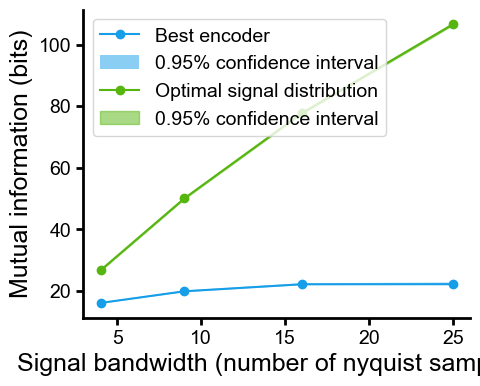

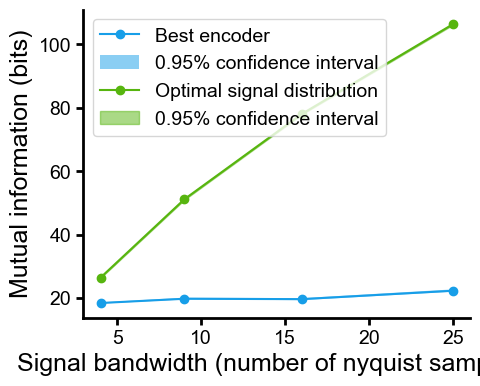

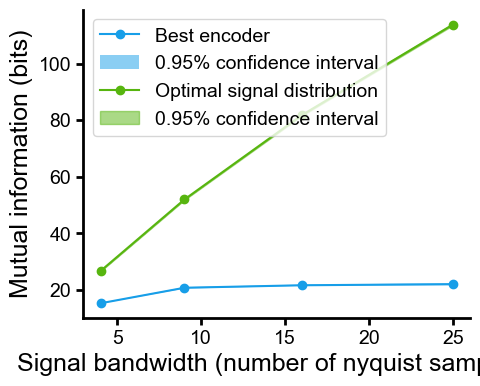

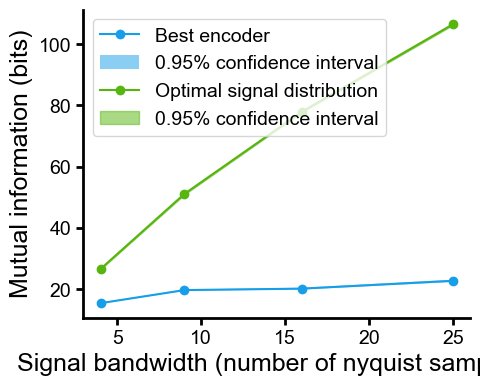

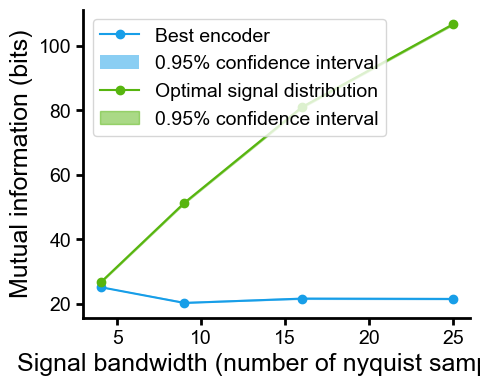

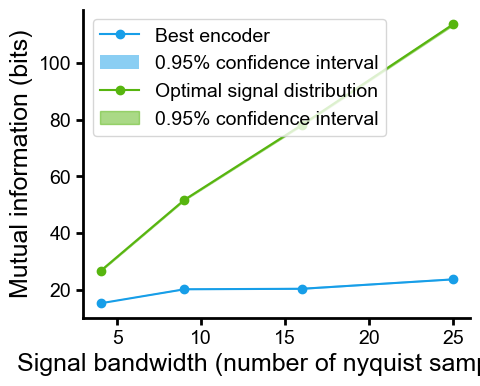

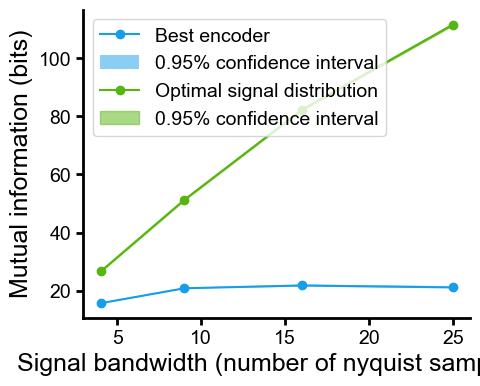

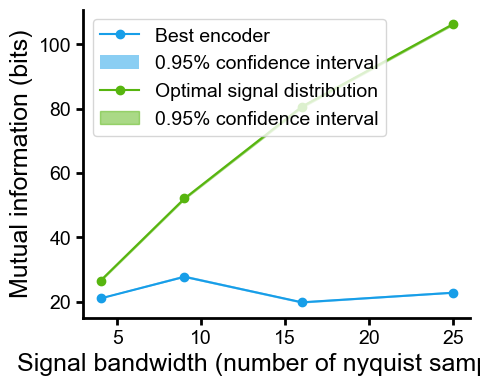

In [5]:
num_nyquist_samples_list = [4, 9, 16, 25]
key = jax.random.PRNGKey(0)
noise_sigma = 1e-3
num_objects = 8000
num_replicates = 15



conv_mi_list = []
uniform_mi_list = []
for i in tqdm(range(num_replicates), desc="Replicates"):
    mi_list = []
    mi_uniform_list = []
    for num_nyquist_samples in tqdm(num_nyquist_samples_list, desc="Nyquist Samples", leave=False):
        upsampled_signal_length = num_nyquist_samples * 32

        # Compute MI for optimized encoder
        conv_info, conv_lower_bound, conv_upper_bound, subkey = compute_mutual_information_for_optimized_encoder(
            num_objects, num_nyquist_samples, noise_sigma, key, upsampled_signal_length=upsampled_signal_length)
        # multiply by number of nyquist samples to get the same scale as the other
        conv_info *= num_nyquist_samples
        conv_lower_bound *= num_nyquist_samples
        conv_upper_bound *= num_nyquist_samples
        mi_list.append((conv_info, conv_lower_bound, conv_upper_bound))
        _, key = jax.random.split(key)

        # Compute MI for uniform samples (if needed per replicate)
        uniform_info, uniform_lower_bound, uniform_upper_bound = compute_uniform_samples_mi(
            num_objects, num_nyquist_samples, noise_sigma, key, upsampled_signal_length=upsampled_signal_length)
        # multiply by number of nyquist samples to get the same scale as the other
        uniform_info *= num_nyquist_samples
        uniform_lower_bound *= num_nyquist_samples
        uniform_upper_bound *= num_nyquist_samples
        mi_uniform_list.append((uniform_info, uniform_lower_bound, uniform_upper_bound))
        _, key = jax.random.split(key)

    
    conv_mi, conv_mi_lower, conv_mi_upper = zip(*mi_list)
    uniform_mi, uniform_mi_lower, uniform_mi_upper = zip(*mi_uniform_list)

    conv_mi_list.append((conv_mi, conv_mi_lower, conv_mi_upper))
    uniform_mi_list.append((uniform_mi, uniform_mi_lower, uniform_mi_upper))

    make_uniform_conv_mi_plot(conv_mi, conv_mi_lower, conv_mi_upper, 
                                uniform_mi, uniform_mi_lower, uniform_mi_upper, num_nyquist_samples_list)
    plt.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'actual_vs_optimal_mi_replicate{i}' + '.pdf', transparent=True)


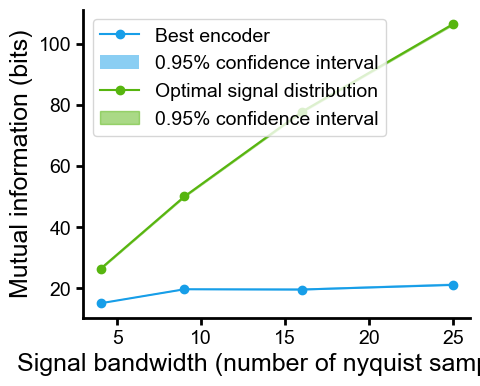

In [6]:
# num replicates x (estimate, lower, upper) x num nyquist samples
conv_mi_list = np.array(conv_mi_list)
best_conv_index = np.argmin(conv_mi_list[:, 0, :], axis=0)
best_conv = conv_mi_list[best_conv_index, np.arange(conv_mi_list.shape[1])[:, None], np.arange(conv_mi_list.shape[2])]
mi_conv, mi_conv_lower, mi_conv_upper = best_conv


uniform_mi_list = np.array(uniform_mi_list)
best_uniform_index = np.argmin(uniform_mi_list[:, 0, :], axis=0)
best_uniform = uniform_mi_list[best_uniform_index, np.arange(uniform_mi_list.shape[1])[:, None], np.arange(uniform_mi_list.shape[2])]
mi_uniform, mi_uniform_lower, mi_uniform_upper = best_uniform


# make_uniform_conv_mi_plot(conv_mi, conv_mi_lower, conv_mi_upper,
#                             uniform_mi, uniform_mi_lower, uniform_mi_upper, num_nyquist_samples_list)
make_uniform_conv_mi_plot(mi_conv, mi_conv_lower, mi_conv_upper,
                            mi_uniform, mi_uniform_lower, mi_uniform_upper, num_nyquist_samples_list)
plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + 'actual_vs_optimal_mi' + '.pdf', transparent=True)

## Make plots of optimal and actual distributions

In [7]:
# generate the signals

def compute_best_encoded_signals(num_objects, num_nyquist_samples, noise_sigma, key,
                                                     upsampled_signal_length=UPSAMPLED_SIGNAL_LENGTH):
    
    objects_fn = lambda : np.array([generate_random_object('delta', object_size=upsampled_signal_length)
                                     for i in range(num_objects)])

    initial_kernel = generate_random_signal(num_nyquist_samples=num_nyquist_samples, unit_energy=True, upsampled_signal_length=upsampled_signal_length)
    initial_params = params_from_signal(initial_kernel, num_nyquist_samples=num_nyquist_samples)
    loss_fn = make_convolutional_forward_model_with_mi_loss(objects_fn(), noise_sigma, num_nyquist_samples=num_nyquist_samples, 
                                                            upsampled_signal_length=upsampled_signal_length)
    optimized_params = run_optimzation(loss_fn, lambda x : signal_prox_fn(x, num_nyquist_samples=num_nyquist_samples), 
                            initial_params,
                              learning_rate=1e-2, learning_rate_decay=0.999,
                              verbose=True,
                            loss_improvement_patience=1000, max_epochs=1000, key=key)

    output_signals = conv_forward_model(optimized_params, objects_fn(), num_nyquist_samples=num_nyquist_samples, integrate_output_signals=False, 
                                        upsampled_signal_length=upsampled_signal_length)
    return key, output_signals

key = jax.random.PRNGKey(0)
noise_sigma = 1e-3
num_objects = 50000

num_nyquist_samples = 4
upsampled_signal_length = num_nyquist_samples * 256

key, signals_encoded = compute_best_encoded_signals(num_objects, num_nyquist_samples, noise_sigma, key,          
                                                        upsampled_signal_length=upsampled_signal_length)
signals_uniform = generate_uniform_random_bandlimited_signals(num_nyquist_samples=num_nyquist_samples, num_signals=num_objects,upsampled_signal_length=upsampled_signal_length)

initial loss -5.135809792908661


Generating signals: 50112it [01:10, 710.10it/s]


concatenating...


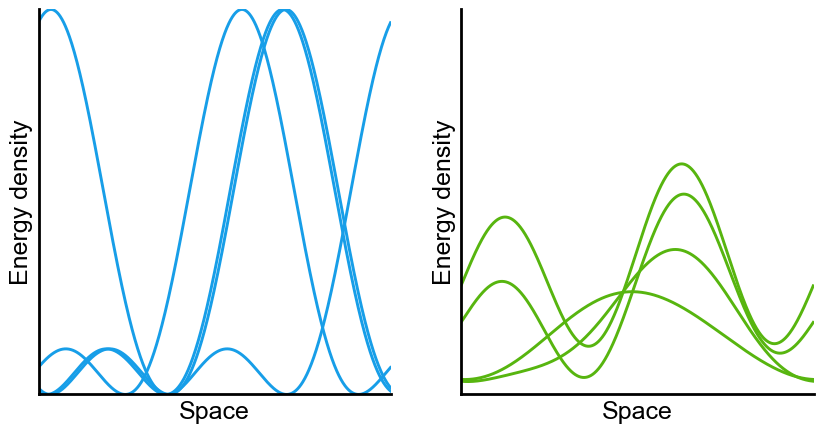

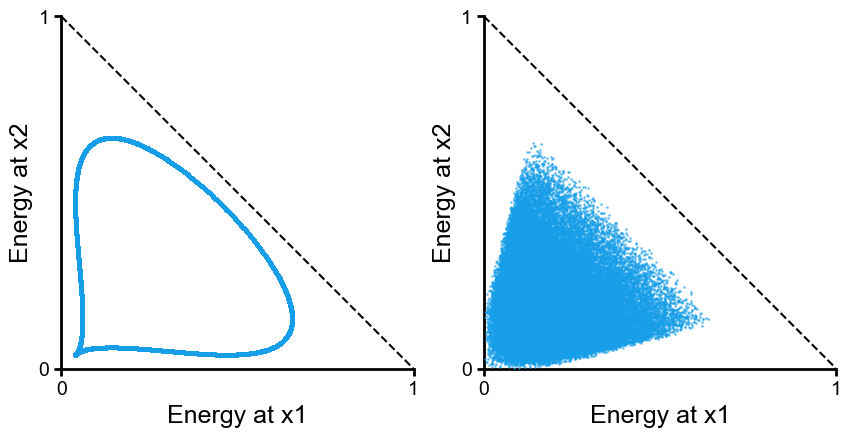

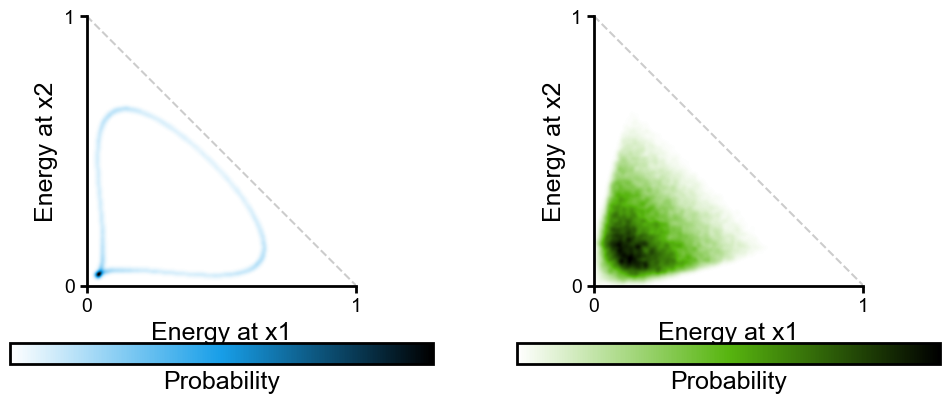

In [8]:
# Make plots
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors



fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ymax = max(onp.max(signals_encoded), onp.max(signals_uniform))
plot_in_spatial_coordinates(ax[0], signals_encoded[:4], num_nyquist_samples=num_nyquist_samples, ymax=ymax, color=get_color_cycle()[0])
plot_in_spatial_coordinates(ax[1], signals_uniform[:4], num_nyquist_samples=num_nyquist_samples, ymax=ymax, color=get_color_cycle()[3])
fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'actual_vs_optimal_example_signals_{num_nyquist_samples}_nyquist' + '.pdf', transparent=True)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_in_intensity_coordinates(ax[0], signals_encoded, num_nyquist_samples=num_nyquist_samples, s=3, alpha=0.5,)
plot_in_intensity_coordinates(ax[1], signals_uniform, num_nyquist_samples=num_nyquist_samples, s=1, alpha=0.5,)


def plot_distribution(ax, x, y, cmap):

    # bin into 2d histogram
    num_bins = 250
    sigma_smooth = 2
    xx, yy = np.meshgrid(np.linspace(0, 1, num_bins), np.linspace(0, 1, num_bins))
    hist, xedges, yedges = np.histogram2d(x, y, bins=[xx[0], yy[:, 0]])
    hist = hist.astype(np.float32)
    hist = gaussian_filter(hist, sigma=sigma_smooth)
    hist /= hist.sum()
    im = ax.imshow(hist.T, origin='lower', extent=[0, 1, 0, 1], cmap=cmap)
    # plot the dotted line from [1, 0] to [0, 1]
    ax.plot([0, 1], [1, 0], '--', color='k', alpha=0.2)
    # add a colorbar to this axis
    colorbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.15)
    colorbar.set_label('Probability')
    colorbar.set_ticks([])  # Hides the ticks
    clear_spines(ax)
    ax.set(yticks=[0, 1], xticks=[0, 1], xlabel='Energy at x1', ylabel='Energy at x2')



fig, ax = plt.subplots(1, 2, figsize=(12, 5))
encoded_integrated = integrate_pixels(signals_encoded, num_nyquist_samples=num_nyquist_samples)
uniform_integrated = integrate_pixels(signals_uniform, num_nyquist_samples=num_nyquist_samples)

cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["white", get_color_cycle()[0], 'black'])
plot_distribution(ax[0], encoded_integrated[:, 0], encoded_integrated[:, 1], cmap)
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["white", get_color_cycle()[3], 'black'])
plot_distribution(ax[1], uniform_integrated[:, 0], uniform_integrated[:, 1], cmap)

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'actual_vs_optimal_distribution_{num_nyquist_samples}_nyquist' + '.pdf', transparent=True)